# HW2

**Author**: Ben Peloquin

**Collaborator**: Marc Harrison
    
**Date**: 20190507

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from scipy.stats import ttest_ind
import seaborn as sns
import sys
import tqdm

from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split

module_path = os.path.abspath(os.path.join('../..'))
sys.path.append(module_path)
print(module_path)
from psych253.cross_validation import get_splits, train_and_test_scikit_classifier
plt.style.use('ggplot')

%matplotlib inline

/Users/benpeloquin/Desktop/PHD/Classes/Psych253


# Setup

In [2]:
data_fp = "../data/ventral_neural_data.hdf5"
d_ventral = h5py.File(data_fp, 'r')
print(d_ventral.keys())

[u'image_meta', u'images', u'neural_meta', u'time_averaged', u'time_averaged_trial_averaged', u'time_binned', u'time_binned_trial_averaged']


In [3]:
chabo_mask = d_ventral['neural_meta']['ANIMAL_INFO'][:] == 'Chabo'
tito_mask = d_ventral['neural_meta']['ANIMAL_INFO'][:] == 'Tito'

chabo_idxs = np.array(range(d_ventral['neural_meta']['ANIMAL_INFO'].shape[0]))[chabo_mask]
tito_idxs = np.array(range(d_ventral['neural_meta']['ANIMAL_INFO'].shape[0]))[tito_mask]

## Question 1: Regression in neural data

In [4]:
v4_idxs = d_ventral['neural_meta']['V4_NEURONS'][:]
it_idxs = d_ventral['neural_meta']['IT_NEURONS'][:]
print(d_ventral['image_meta'].keys())
d_all_sizes = d_ventral['image_meta']['size'][:]

[u'category', u'object_name', u'rotation_xy', u'rotation_xz', u'rotation_yz', u'size', u'translation_y', u'translation_z', u'variation_level']


In [5]:
# Features are neurons, prediction is size
X_v4 = d_ventral['time_averaged_trial_averaged'][:, v4_idxs[:-40]]  # Remove bad last 40
X_it = d_ventral['time_averaged_trial_averaged'][:, it_idxs]
datas = [('V4', X_v4), ('IT', X_it)]
y = d_all_sizes[:]
assert(map(lambda x: x[1].shape[0]==y.shape[0], datas))

### Question 1.1: Size regression from neural responses

#### 1.1.1.a OLS regression

In [6]:
def get_random_sample(X, size):
    """Helper for IT neurons"""
    sample_idxs = random.sample(range(X.shape[len(X.shape)-1]), k=size)
    return X[:, sample_idxs]

def get_split_idxs(total, train_prop=0.8, max_size=None):
    """Return train and test split of indices.
    
    Parameters
    ----------
    total: int
        Number indices.
    train_prob: float [Default: 0.8]
        Train size.
    max_size: int [Default: None]
        Limit max size (for sub-sampling)
    
    Returns
    -------
    tuple
        Train and test indices.

    """
    all_idxs = [i for i in range(total)]
    np.random.shuffle(all_idxs)
    if max_size is not None and max_size < total:
        all_idxs = all_idxs[:max_size]
    Xs = set(all_idxs[:int(len(all_idxs)*train_prop)])
    ys = set(all_idxs) - Xs
    return np.array(list(Xs)), np.array(list(ys))

def r_squared(predicted, actual):
    """The "rsquared" metric
    """
    a_mean = actual.mean()
    num = np.linalg.norm(actual - predicted)**2
    denom = np.linalg.norm(actual - a_mean)**2
    return 1 - num / denom

def run_model(model_klass, X_train, y_train, X_test, y_test, eval_fn=r_squared):
    """Run model helper.
    
    Parameters
    ----------
    model_klass: sklearn model object
        Sklearn model.
    X_train: np.array (num_examples, num_features)
        Train features.
    y_train: np.array (num_examples, )
        Train supervision.
    X_test: np.array (num_examples, num_features)
        Test features.
    y_test: np.array (num_examples, )
        Test supervision.
        
    Returns
    -------
    tuple
        Tuple of (float, float, sklearn object)
    
    """
    model = model_klass.fit(X_train, y_train)
    # Preds
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_loss = eval_fn(train_preds, y_train)
    test_loss = eval_fn(test_preds, y_test)
    return train_loss, test_loss, model

In [7]:
n_sims = 20
max_size = 88
train_prop = 0.8

In [8]:
d_results = []
for sim_idx in tqdm.tqdm(range(n_sims)):
    train_idxs, test_idxs = current_indices = \
            get_split_idxs(len(y), train_prop)
    X_it_partial = get_random_sample(X_it, size=max_size)
    datas.append(("IT_partial", X_it_partial))
    for roi, X in datas:
        # Partition into train and test
        X_train = X[train_idxs, :]
        y_train = y[train_idxs]
        X_test = X[test_idxs, :]
        y_test = y[test_idxs]

        # Fit model
        train_perf, test_perf, _ = \
            run_model(LinearRegression(), X_train, y_train, X_test, y_test)
        
        d_results.append({
            "sim_idx": sim_idx,
            "roi": roi,
            "train_r2": train_perf,
            "test_r2": test_perf
        })

df_results = pd.DataFrame(d_results)

100%|██████████| 20/20 [00:01<00:00,  7.98it/s]


In [9]:
df_results \
    .groupby(['roi'])['test_r2'] \
    .aggregate({np.mean, np.std}) \
    .reset_index()

,roi,mean,std
0,IT,0.361533,0.019720
1,IT_partial,0.315505,0.025704
2,V4,0.136154,0.018673


/Users/benpeloquin/anaconda/envs/py27/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


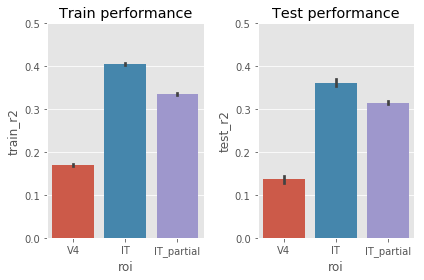

In [10]:
plt.subplot(121)
sns.barplot(x='roi', y='train_r2', ci=95, data=df_results)
plt.ylim(0, 0.5)
plt.title("Train performance")
plt.subplot(122)
sns.barplot(x='roi', y='test_r2', ci=95, data=df_results)
plt.ylim(0, 0.5)
plt.title("Test performance")
plt.tight_layout()

Let's run a t-test between the sub-sampled IT and V4

In [11]:
a = df_results[df_results['roi']=='V4'].test_r2
b = df_results[df_results['roi']=='IT_partial'].test_r2
ttest_ind(a, b)

Ttest_indResult(statistic=-30.42143004222995, pvalue=3.2062083268948905e-82)

Comparing average $r^2$ between V4 and subsampled IT we see a significant difference (IT is higher).

#### 1.1.1.b  Ridge regression

In [12]:
n_sims = 30
max_size = 88
train_prop = 0.8
alphas = [1e-7, 1e-5, 1e-3, 1e-2, 1e-1, 1, 10, 100]
models = [("ridge_{}".format(alpha), Ridge(alpha=alpha)) for alpha in alphas]
models.append(("ols", LinearRegression()))

In [13]:
d_results = []
for sim_idx in tqdm.tqdm(range(n_sims)):
    train_idxs, test_idxs = current_indices = \
            get_split_idxs(len(y), train_prop)
    X_it_partial = get_random_sample(X_it, size=max_size)
    datas.append(("IT_partial", X_it_partial))
    for roi, X in datas:
        # Partition into train and test
        X_train = X[train_idxs, :]
        y_train = y[train_idxs]
        X_test = X[test_idxs, :]
        y_test = y[test_idxs]
        for model_nam, model in models:
            # Fit model
            train_perf, test_perf, _ = \
                run_model(model, X_train, y_train, X_test, y_test)

            d_results.append({
                "sim_idx": sim_idx,
                "model_name": model_nam,
                "roi": roi,
                "train_r2": train_perf,
                "test_r2": test_perf
            })

df_results = pd.DataFrame(d_results)

100%|██████████| 30/30 [00:34<00:00,  1.41s/it]


In [14]:
d_best = []
for roi, group in (df_results \
    .groupby(["model_name", "roi"])[["test_r2"]] \
    .aggregate({np.mean}) \
    .reset_index() \
    .groupby("roi")):
    best_idx = group['test_r2'].idxmax().values[0]
    r2 = group[group.index==best_idx].test_r2.values[0][0]
    model_name_ = group[group.index==best_idx].model_name.values[0]
    d_best.append({
        "roi": roi,
        "model": model_name_,
        "r2": r2
    })
df_best = pd.DataFrame(d_best)

In [15]:
df_best

,model,r2,roi
0,ridge_100,0.362808,IT
1,ridge_10,0.307976,IT_partial
2,ridge_100,0.137855,V4


In [16]:
best_models = zip(df_best.roi.values, df_best.model.values)
best_models

[('IT', 'ridge_100'), ('IT_partial', 'ridge_10'), ('V4', 'ridge_100')]

In [17]:
# Filter best models
df_bests = pd.concat(
    [df_results[(df_results.roi == roi) & (df_results.model_name==model)] for roi, model in best_models])

In [18]:
df_bests["best_model_for_roi"] = \
    df_bests.apply(lambda x: "{}_{}".format(x["roi"], x["model_name"]), axis=1)

Text(0.5,1,'Best model by ROI')

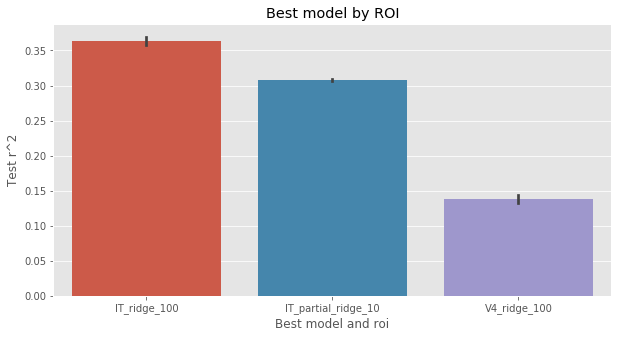

In [19]:
plt.figure(figsize=(10, 5))
sns.barplot(x="best_model_for_roi", y="test_r2", ci=95, data=df_bests)
plt.xlabel("Best model and roi")
plt.ylabel("Test r^2")
plt.title("Best model by ROI")

**Todo RidgeCV**

### Question 1.1.2: Predicting neural responses from neural responses

In [20]:
chabo_v4_idxs = set(v4_idxs) & set(chabo_idxs)
tito_v4_idxs = set(v4_idxs) & set(tito_idxs[:-40])

# Only good v4 from both animal
X_chabo_v4 = d_ventral['time_averaged_trial_averaged'][:, chabo_v4_idxs]
X_tito_v4 = d_ventral['time_averaged_trial_averaged'][:, tito_v4_idxs] 

Let's predict `tito` from `chabo`.

In [21]:
n_sims = 30
train_prob = 0.8
max_size = None
models = [("ridge", RidgeCV(alphas=alphas)), ("lasso", LassoCV(alphas=alphas))]

In [22]:
import warnings
warnings.filterwarnings('ignore')

y = X_tito_v4[:, 0]
X = X_chabo_v4
d_results3 = []
for sim_idx in tqdm.tqdm(range(n_sims)):
    train_idxs, test_idxs = current_indices = \
            get_split_idxs(len(y), train_prop)
    for model_name, model in models:
        # Partition into train and test
        X_train = X[train_idxs, :]
        y_train = y[train_idxs]
        X_test = X[test_idxs, :]
        y_test = y[test_idxs]
        train_perf, test_perf, model_ = \
            run_model(model, X_train, y_train, X_test, y_test)

        d_results3.append({
            "sim_idx": sim_idx,
            "model_name": model_name,
            "hyperparam": model_.alpha_,
            "train_r2": train_perf,
            "test_r2": test_perf
        })

df_results3 = pd.DataFrame(d_results3)

100%|██████████| 30/30 [00:02<00:00, 12.27it/s]


In [23]:
df_results3 \
    .groupby(["model_name", "hyperparam"])["test_r2"] \
    .aggregate({np.mean, np.std, "count"}) \
    .reset_index()
    

,model_name,hyperparam,count,mean,std
0,lasso,0.00001,7,0.396880,0.018057
1,lasso,0.00100,23,0.401716,0.018233
2,ridge,10.00000,30,0.404297,0.019052


The last time we ran this `1e-3` had the second highest mean value, but was most often found to have the best r^2 value. So we're going to set the best Lasso to `1e-3`. Clearly it's `10` for Ridge.

In [24]:
best_ridge = Ridge(alpha=10)
best_lasso = Lasso(alpha=1e-3)
models = [("ridge", best_ridge), ("lasso", best_lasso)]

In [25]:
n_sims = 100
train_prop = 0.8

for sim_idx in tqdm.tqdm(range(n_sims)):
    train_idxs, test_idxs = current_indices = \
            get_split_idxs(len(y), train_prop)
    for model_name, model in models:
        # Partition into train and test
        X_train = X[train_idxs, :]
        y_train = y[train_idxs]
        X_test = X[test_idxs, :]
        y_test = y[test_idxs]
        train_perf, test_perf, model_ = \
            run_model(model, X_train, y_train, X_test, y_test)

        d_results3.append({
            "sim_idx": sim_idx,
            "model_name": model_name,
            "train_r2": train_perf,
            "test_r2": test_perf
        })

100%|██████████| 100/100 [00:01<00:00, 89.29it/s]


## Question 1.2: Regression in self-regulation ontology data

#### 1.2.1 Data explanation

#### 1.2.2 Reliability of task and survey measures